# Principal Components Analysis

PCA is an unsupervised machine learning model that intends to reduce the dimensionality of the data while preserving as much variability as possible.

It transforms the original features (given by the columns) into a smaller set of new uncorrelated variables called principal components. These components are linear combinations of the original features.

PCA is commonly use to simplify datasets, reduce noise and avoid collinearilty. It's often used as an initial data process before some other supervised learning technique to predict a target variable.

The following image from [Medium](https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d) shows an example of how PCA can help to reduce the dimensionality of a 3D dataset by seeing the projection in a 2D plane.

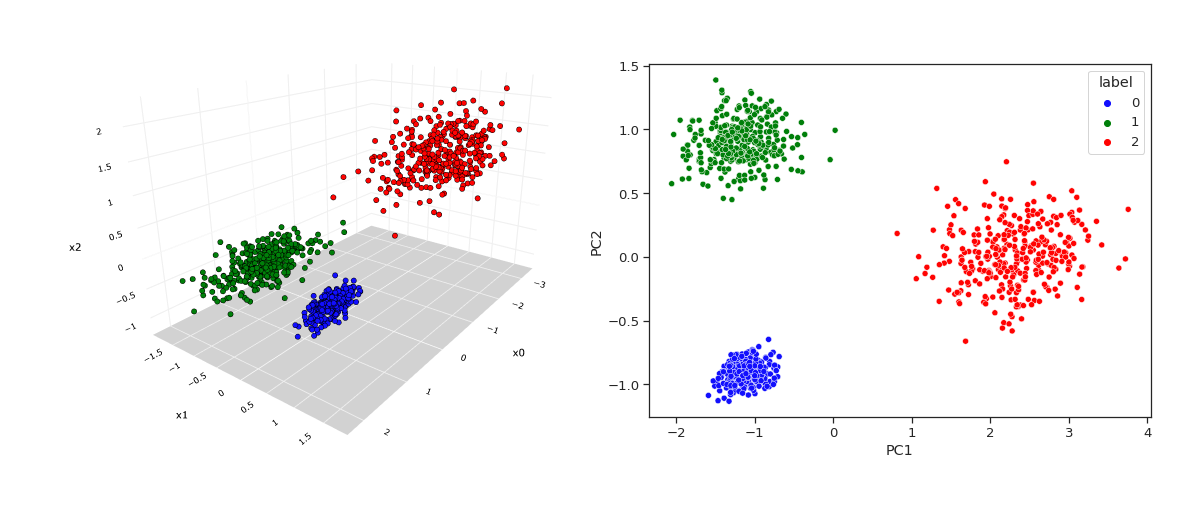



For this project, we will study a dataset of around 27000 images of women and men and we will intend to recognize the gender of the person in the image using PCA and Logistic Classification. The idea for this project is:

1. Use PCA to reduce the dimensionality of the photos.
2. See how PCA reconstructs the image limiting the number of components.
3. Implement a Logistic Classification model to predict the gender based on the principal components selected through PCA.
4. Try different number of components to build different models and see how the number of components can affect the accuracy of the model.

**Dataset: Biggest gender/face recognition dataset from Kaggle**

We start by processing the dataset composed of images.

In [43]:
# First, we import necessary libraries
import numpy as np
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [44]:
# We open the dataset from Kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [45]:
!kaggle datasets download -d maciejgronczynski/biggest-genderface-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset
License(s): CC0-1.0
biggest-genderface-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
!unzip biggest-genderface-recognition-dataset.zip -d gender_faces

Archive:  biggest-genderface-recognition-dataset.zip
replace gender_faces/faces/man/man_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [48]:
# Define the paths
base_dir = 'gender_faces/faces'
male_dir = os.path.join(base_dir, 'man')
female_dir = os.path.join(base_dir, 'woman')



Let's see a sample of a male and female image

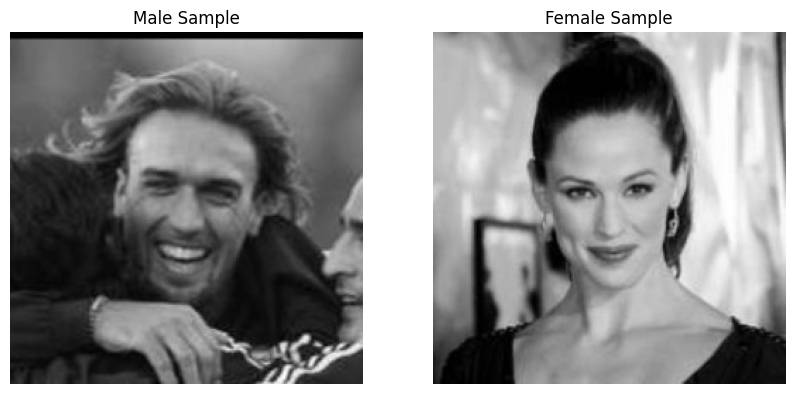

In [49]:
# We load a sample male and female image
male_sample = cv2.imread(os.path.join(male_dir, os.listdir(male_dir)[0]), cv2.IMREAD_GRAYSCALE)
female_sample = cv2.imread(os.path.join(female_dir, os.listdir(female_dir)[0]), cv2.IMREAD_GRAYSCALE)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Male Sample")
plt.imshow(male_sample, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female Sample")
plt.imshow(female_sample, cmap='gray')
plt.axis('off')

plt.show()

In [50]:
# We assign labels for the images
def preprocess_images(folder):
    images = []
    labels = []
    for label, gender in enumerate(['man', 'woman']):  # 0 for 'man', 1 for 'woman'
        gender_path = os.path.join(folder, gender)
        for file in os.listdir(gender_path):
            img = cv2.imread(os.path.join(gender_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (100, 100))  # Resize to 100x100
                images.append(img.flatten())  # Flatten the image
                labels.append(label)
    return np.array(images), np.array(labels)

# Preprocess the dataset
X, y = preprocess_images(base_dir)
print(f"Loaded {len(X)} images.")

Loaded 27167 images.


In [51]:
# We see if the dataset is balanced
print("Class distribution before balancing:", np.bincount(y))


Class distribution before balancing: [17678  9489]


In [52]:
# Separate images by gender
X_male = X[y == 0]  # Images corresponding to the 'male' class
X_female = X[y == 1]    # Images corresponding to the 'female' class

# Print the shapes to verify
print("Number of female images:", X_female.shape[0])
print("Number of male images:", X_male.shape[0])





Number of female images: 9489
Number of male images: 17678


**Oversampling**

Since the dataset is imbalanced, we will oversample females to match the number of males and avoid possible errors related to imbalances in the dataset.

In [53]:
# We oversample females to match the number of males using resample from sklearn
X_female_oversampled = resample(
    X_female,
    replace=True,                   # Sample with replacement
    n_samples=len(X_male),          # Match the number of males
    random_state=42
)

# Create new labels for the oversampled females
y_female_oversampled = np.zeros(len(X_female_oversampled))  # Label: 0 (Female)

# Combine the oversampled females with the original males
X_balanced = np.vstack((X_female_oversampled, X_male))
y_balanced = np.hstack((y_female_oversampled, np.ones(len(X_male))))  # Label: 1 (Male)

# Verify the new class distribution
print("Balanced dataset shape:", X_balanced.shape)
print("Balanced labels distribution:", np.bincount(y_balanced.astype(int)))


Balanced dataset shape: (35356, 10000)
Balanced labels distribution: [17678 17678]


**PCA and Logistic Regression Classifier**

Now that the dataset is balanced, we proceed to use PCA to determine the N principal components to chareacterize the images.

We will start with N=20.

In [54]:
X,y = X_balanced, y_balanced

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA with 20 components
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [55]:
# We initiate the Logistic Regression Classifier
clf = LogisticRegression(max_iter=2000, random_state=42)

# Train the model on the training data
clf.fit(X_train_pca, y_train)



LogisticRegression(max_iter=2000, random_state=42)

In [57]:
# We make the predictions
y_pred = clf.predict(X_test_pca)


In [58]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      3563
         1.0       0.67      0.67      0.67      3509

    accuracy                           0.67      7072
   macro avg       0.67      0.67      0.67      7072
weighted avg       0.67      0.67      0.67      7072

Accuracy: 67.35%


The results show that, with only 20 components, the model achieves an accuracy of 67%. This is impressive, considering the original images had 10,000 components (as they were resized to 100x100 pixels). In other words, the model has reduced the dimensionality by 98% while still predicting gender significantly better than random chance. This demonstrates the model's ability to extract meaningful features from a drastically compressed representation of the data.

Let's now build a confusion matrix to gain more insights on how the model is working.

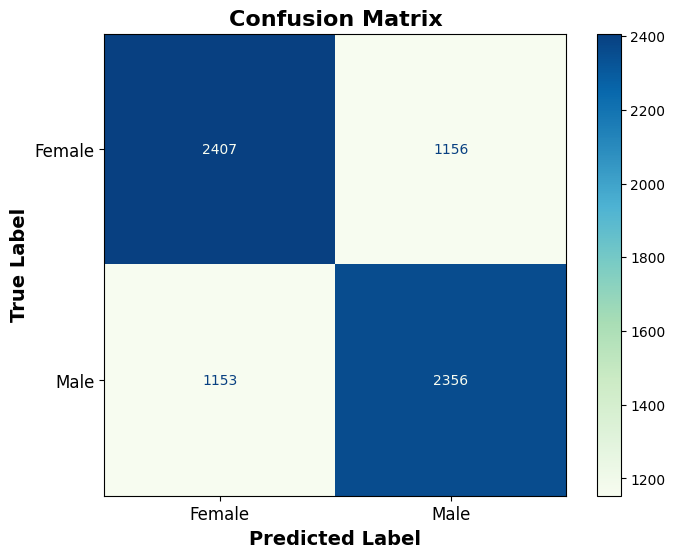

In [59]:
# We build the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap='GnBu', ax=ax, colorbar=True)
ax.set_title("Confusion Matrix", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



By looking at the confusion matrix, we can see that the model correctly predicted 2395 female images and 2354 male images. On the other hand, it missed to classify 1155 male images and 1168 female images. This shows that the model may be missing key patterns associated with female and male characteristics.

Let's see how the PCA is reconstructing the images.

In [60]:
X_train_reconstructed = pca.inverse_transform(X_train_pca)  # Reconstruct the images


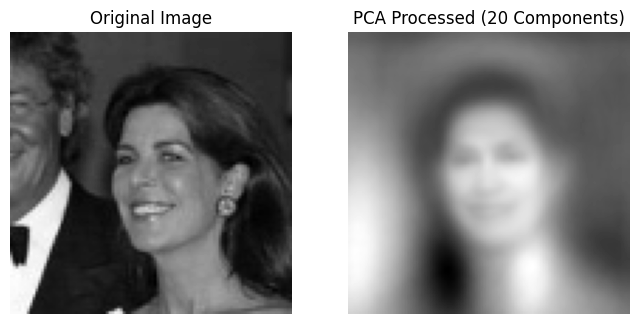

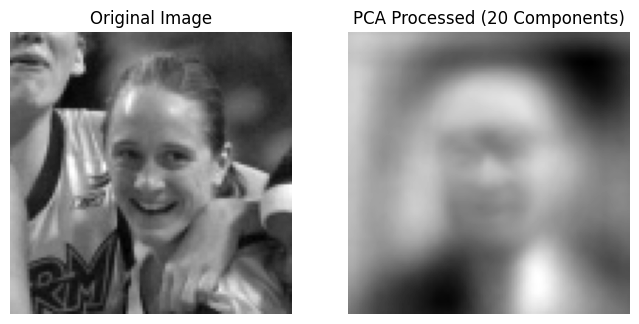

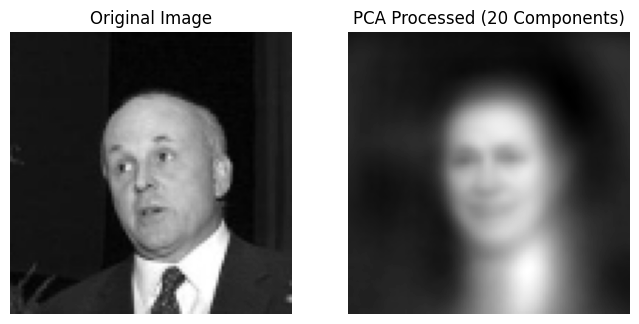

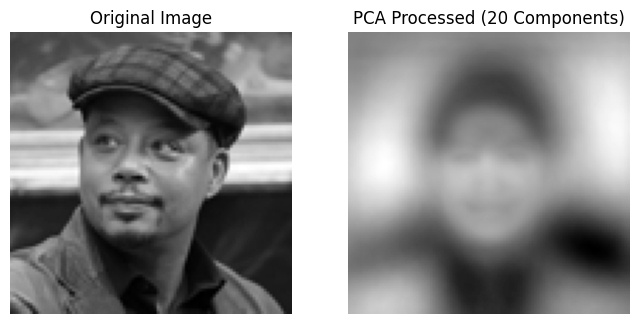

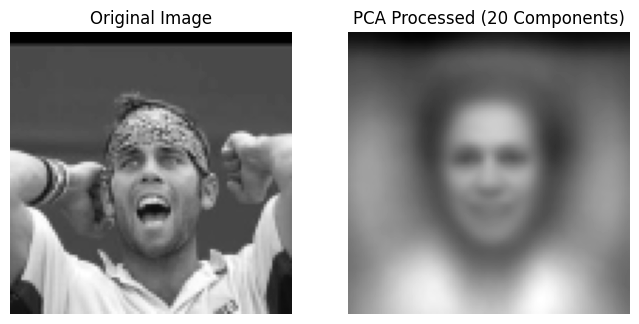

In [61]:
# Visualize the first 5 images

for i in range(5):
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i].reshape(100, 100), cmap='gray')  # Adjust shape to your image size
    plt.title("Original Image")
    plt.axis('off')

    # Reconstructed image from PCA
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_reconstructed[i].reshape(100, 100), cmap='gray')  # Adjust shape
    plt.title("PCA Processed (20 Components)")
    plt.axis('off')

    plt.show()

We can see that the model is recreating the images but they are lacking a lot of important information to differentiate genders. Even as a human, it's difficult to predict the gender by looking at the PCA processed images.

Let's try to vary the number of components for the PCA and see if we can obtain a higher accuracy.

**Elbow method to determine optimal number of components for PCA**

Let's perform the elbow method to determine an optimal number of components for the PCA. This method involves plotting the cumulative variance ratio against the number of components and identifying the 'elbow point' where the rate of explained variance starts to level off.

In [62]:
# We will limit the number of components to 500 because of memory capacity
max_components = 500
pca = PCA(n_components=max_components)
pca.fit(X_train)



PCA(n_components=500)

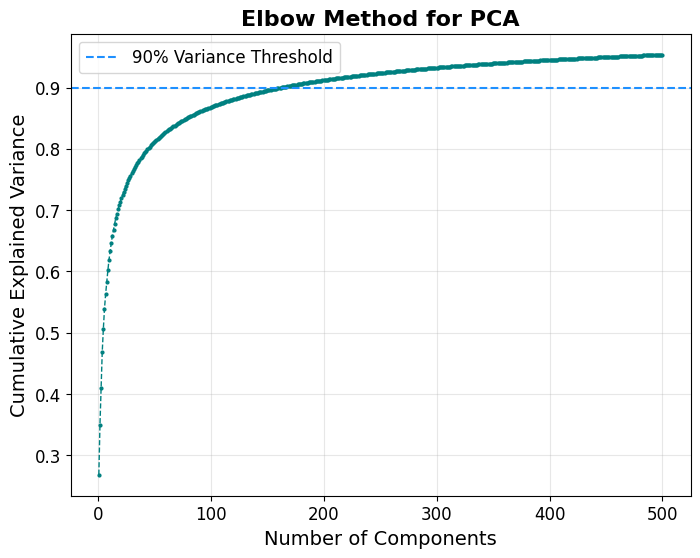

In [63]:
# Calculate cumulative explained variance and plot
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    markersize=2,
    linestyle='--',
    color='teal',
    linewidth=1
)
plt.title('Elbow Method for PCA', fontsize=16, fontweight='bold')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.axhline(y=0.9, color='dodgerblue', linestyle='--', label='90% Variance Threshold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the improved plot
plt.show()

From the graph, we can see that the 90% variance threshold is reached for N=150 (approximately). This means that increasing the number of components after 150 won't be significant to explain more of the variance.

Let's build the model with 150 components.

In [64]:
# Apply PCA with N=150
pca = PCA(n_components=150)
X_train_pca= pca.fit_transform(X_train)

In [65]:
# We reconstruct the images to see how the PCA with 150 components is working
X_train_reconstructed = pca.inverse_transform(X_train_pca)

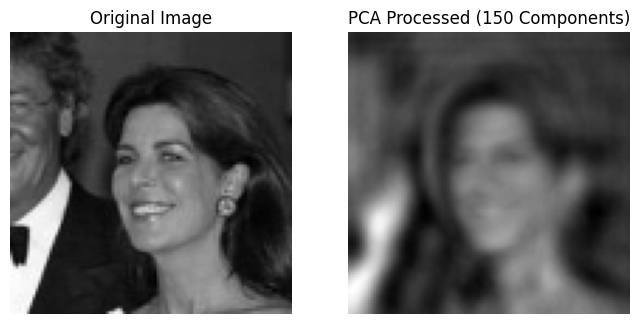

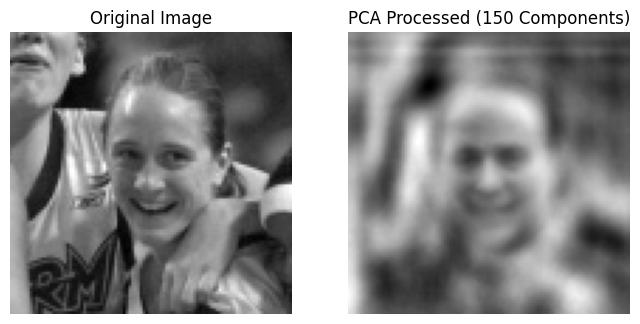

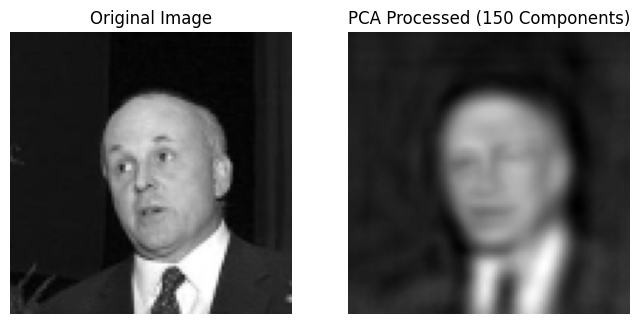

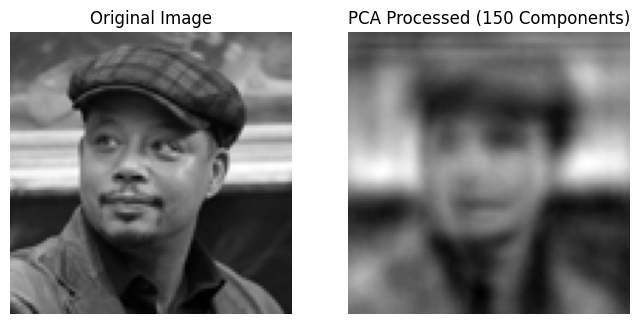

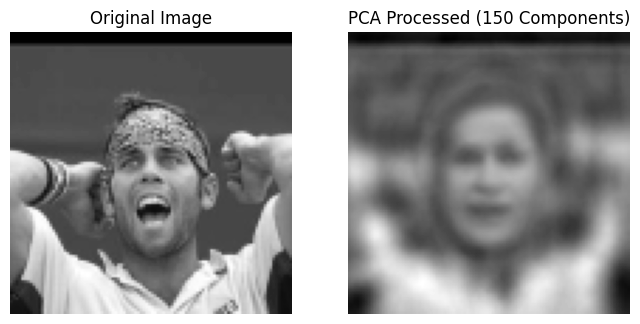

In [66]:
# Visualize the first 5 images
for i in range(5):
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i].reshape(100, 100), cmap='gray')  # Adjust shape to your image size
    plt.title("Original Image")
    plt.axis('off')

    # Reconstructed image from PCA
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_reconstructed[i].reshape(100, 100), cmap='gray')  # Adjust shape
    plt.title("PCA Processed (150 Components)")
    plt.axis('off')

    plt.show()

We can see that adding components to the model helps to obtain more clear images, and the characteristic physical aspects of men and women are more defined. However, 150 components is still very low comparing to the original 10,000 components of each image (1.5%).

Let's see how the classifier works with 150 features.

In [67]:
# We build the classifier
# We initialize the classifier
clf = LogisticRegression(max_iter=2000, random_state=42)

# Train the model on the training data
clf.fit(X_train_pca, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [68]:
X_test_pca = pca.transform(X_test)

In [69]:
y_pred = clf.predict(X_test_pca)

In [70]:
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      3563
         1.0       0.72      0.71      0.72      3509

    accuracy                           0.72      7072
   macro avg       0.72      0.72      0.72      7072
weighted avg       0.72      0.72      0.72      7072

Accuracy: 72.20%


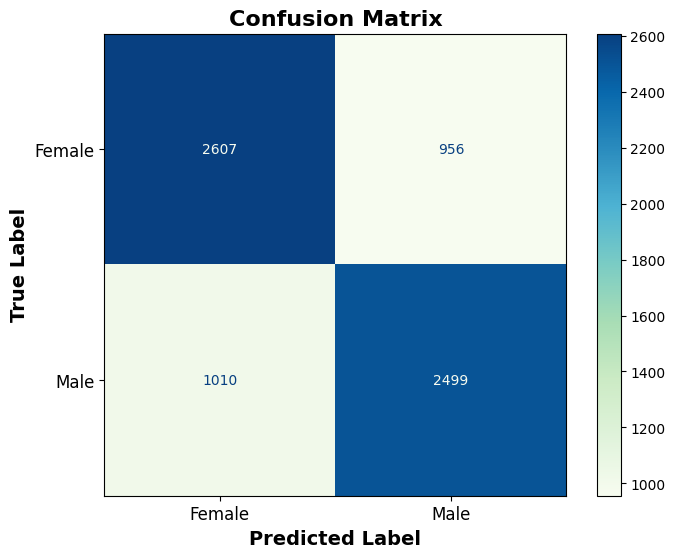

In [71]:
# We build the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap='GnBu', ax=ax, colorbar=True)
ax.set_title("Confusion Matrix", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


We can see that the model with 150 components is working much better than the one with 20 components, with an accuracy of almost 72%.

**Predicting our genders!**

Let's see if the model can predict our genders now :)

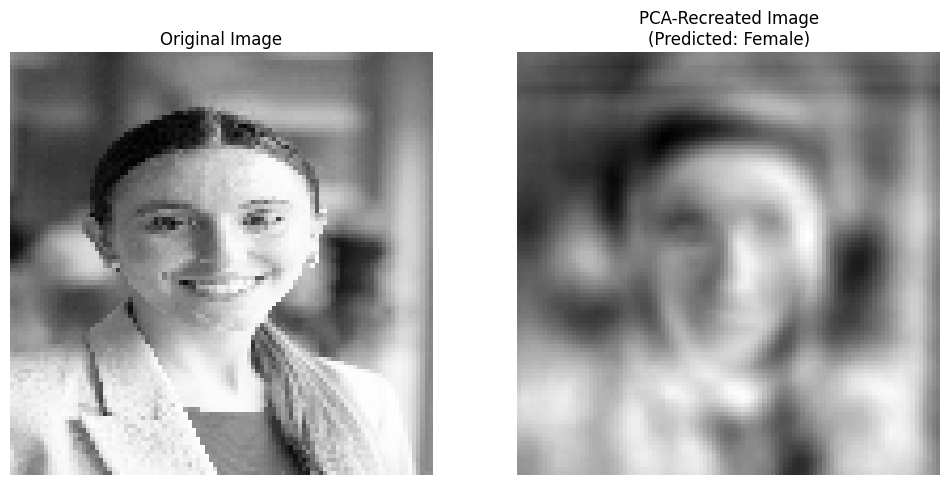

The predicted label for Valentina is: Female


In [75]:
# Function to preprocess and classify an image
def classify_and_visualize(image_path, pca, clf):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or unable to load.")

    # Preprocess the image (resize and flatten)
    img_resized = cv2.resize(img, (100, 100))  # Resize to match training size
    img_flattened = img_resized.flatten().reshape(1, -1)  # Flatten and reshape for PCA

    # Apply PCA to reduce dimensions
    img_pca = pca.transform(img_flattened)  # Transform image using PCA

    # Reconstruct the image from PCA for visualization
    img_reconstructed = pca.inverse_transform(img_pca).reshape(100, 100)

    # Predict using the trained classifier
    prediction = clf.predict(img_pca)

    # Map prediction to class label
    label_map = {0: "Female", 1: "Male"}
    predicted_label = label_map[prediction[0]]

    # Plot the original and reconstructed images
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title(f"PCA-Recreated Image\n(Predicted: {predicted_label})")
    plt.axis('off')

    plt.show()

    return predicted_label


# Path to the image
image_path = "/content/drive/Shareddrives/Ceci y Vale/INDE 577/untitled (110 of 238).jpg"

# Classify and visualize the image
predicted_label = classify_and_visualize(image_path, pca, clf)
print(f"The predicted label for Valentina is: {predicted_label}")

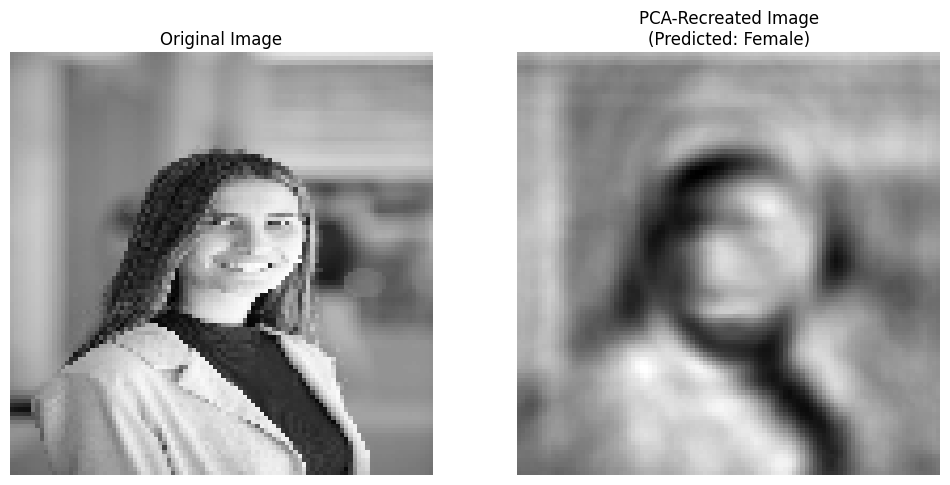

The predicted label for Cecilia is: Female


In [77]:
image_path2= "/content/drive/Shareddrives/Ceci y Vale/INDE 577/WhatsApp Image 2024-11-19 at 12.28.02.jpeg"
# Classify and visualize the image
predicted_label = classify_and_visualize(image_path2, pca, clf)
print(f"The predicted label for Cecilia is: {predicted_label}")